In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import pandas as pd

In [21]:
df = pd.read_csv('../datasets/mensagens_com_frequencia_somente_mensagens_portugues.csv')
df.head()

,texto_original,frequencia,texto_limpo,text_processed,idioma
0,▪️ 01/11/2022 - 08:00 \n\nÁsia-Pacífico (fecha...,10,01112022 0800 asiapacifico fechado spasx 165 6...,01112022 0800 asiapacifico fechado spasx 165 6...,pt
1,02.10.2022 TSE - Presidente - às 18h 55m 31s,10,02102022 tse presidente as 18h 55m 31s,02102022 tse presidente 18h 55m 31s,pt
2,*02.10.2022 TSE - Presidente às 20h 02m 45s*,3,02102022 tse presidente as 20h 02m 45s,02102022 tse presidente 20h 02m 45s,pt
3,02.10.2022 TSE - Presidente às 22h 21m 36s,2,02102022 tse presidente as 22h 21m 36s,02102022 tse presidente 22h 21m 36s,pt
4,02.10.2022 TSE - Prévia das 17h 44m 10s,2,02102022 tse previa das 17h 44m 10s,02102022 tse previa 17h 44m 10s,pt


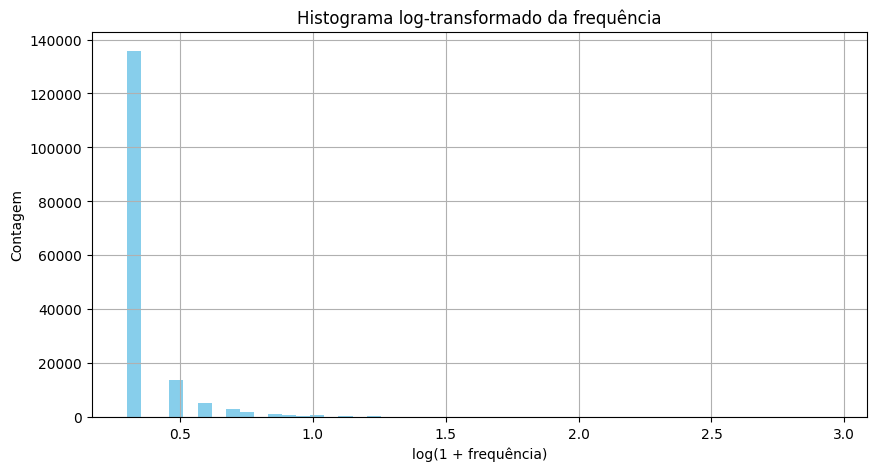

In [22]:

plt.figure(figsize=(10,5))
#plt.hist(np.log1p(df['frequencia']), bins=50, color='skyblue')
plt.hist(np.log1p(df['frequencia']) / np.log(10), bins=50, color='skyblue')
plt.title("Histograma log-transformado da frequência")
plt.xlabel("log(1 + frequência)")
plt.ylabel("Contagem")

plt.grid(True)
plt.show()

## Segmentação baseada em vales entre picos com suavização

Cortes finais na escala original: [  2.91444844   6.20772782  12.27168851  20.62860061 193.75495063]
Cortes iniciais: [ 1.34756726  8.65421418 11.04120306]


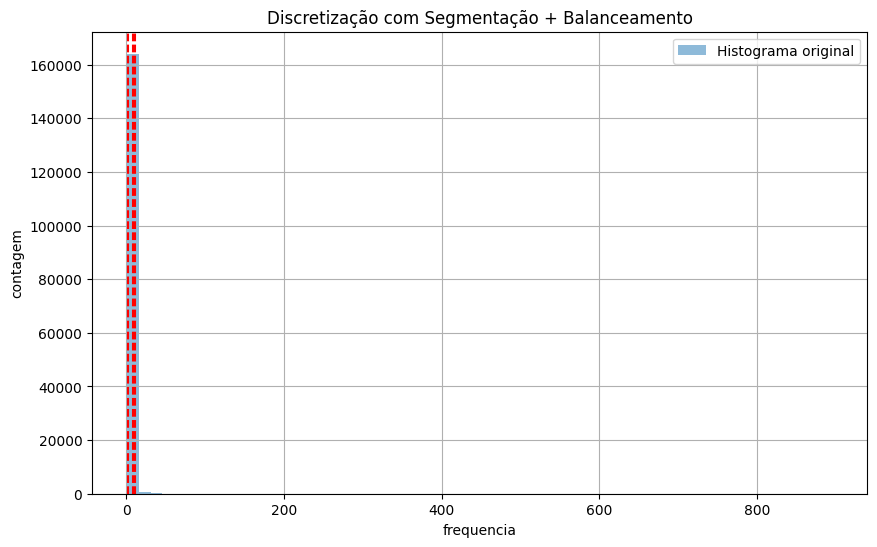

Distribuição das classes:
classe
0    0.823
1    0.167
2    0.010
Name: proportion, dtype: float64


In [23]:

x = np.log1p(df['frequencia'].values)  # Transformação logarítmica para cauda longa

# 1. Criar histograma
hist, bin_edges = np.histogram(x, bins=50)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# 2. Suavização do histograma (média móvel)
smooth_hist = np.convolve(hist, np.ones(3)/3, mode='same')

# 3. Identificar picos (máximos) e vales (mínimos)
picos, _ = find_peaks(smooth_hist)
vales, _ = find_peaks(-smooth_hist)

# 4. Aplicar critério do artigo (thresholds entre picos)
K = 1.0
thresholds_log = []

for vale in vales:
    left_picos = picos[picos < vale]
    right_picos = picos[picos > vale]
    
    if len(left_picos) > 0 and len(right_picos) > 0:
        g_i = smooth_hist[vale]
        g_j = smooth_hist[left_picos[-1]]  # último pico à esquerda
        g_k = smooth_hist[right_picos[0]]  # primeiro pico à direita

        if (g_j + g_k)/2 > K * g_i:
            thresholds_log.append(bin_centers[vale])

# 5. Voltar para escala original
cut_points = np.expm1(thresholds_log)
cut_points = np.array(sorted(cut_points))
print("Cortes finais na escala original:", cut_points)

# 6. Discretizar os dados
df['classe'] = np.digitize(df['frequencia'], bins=cut_points)

# ==== 1. Carregar os dados ====
frequencia_original = df['frequencia'].values

# ==== 2. Transformar a variável (log1p) ====
# x_log = np.log1p(frequencia_original)
x_log = np.log1p(frequencia_original) / np.log(10)  # log base 10
#x_log = np.log1p(np.log1p(df['frequencia'].values))

# ==== 3. Criar histograma ====
bins = 60  # mais resolução
hist, bin_edges = np.histogram(x_log, bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ==== 4. Suavização ====
hist_smooth = np.convolve(hist, np.ones(3)/3, mode='same')

# ==== 5. Encontrar picos e vales ====
picos, _ = find_peaks(hist_smooth)
vales, _ = find_peaks(-hist_smooth)

# ==== 6. Aplicar critério do artigo para cortes ====
K = 1.2
thresholds_log = []

for vale in vales:
    left_picos = picos[picos < vale]
    right_picos = picos[picos > vale]
    
    if len(left_picos) > 0 and len(right_picos) > 0:
        g_i = hist_smooth[vale]
        g_j = hist_smooth[left_picos[-1]]  # pico à esquerda
        g_k = hist_smooth[right_picos[0]]  # pico à direita

        if (g_j + g_k) / 2 > K * g_i:
            thresholds_log.append(bin_centers[vale])

# ==== 7. Voltar para escala original ====
cut_points = np.expm1(sorted(thresholds_log))
print("Cortes iniciais:", cut_points)

# ==== 8. Discretizar ====
df['classe'] = np.digitize(frequencia_original, bins=cut_points)

# ==== 9. Balanceamento – remover classes pequenas ====
min_percent = 0.01  # 1% do total
min_count = int(len(df) * min_percent)
classe_counts = df['classe'].value_counts().sort_index()

# Ajustar classes pequenas
for c in classe_counts.index:
    if classe_counts[c] < min_count:
        # Reatribui a classe para a anterior (ou 0 se for a primeira)
        nova_classe = max(0, c - 1)
        df.loc[df['classe'] == c, 'classe'] = nova_classe

# Reindexar as classes (opcional, para ter 0, 1, 2, ...)
df['classe'] = df['classe'].astype(int)
unique_classes = sorted(df['classe'].unique())
classe_mapeada = {old: new for new, old in enumerate(unique_classes)}
df['classe'] = df['classe'].map(classe_mapeada)

# ==== 10. Visualizar resultado ====
plt.figure(figsize=(10, 6))
plt.hist(frequencia_original, bins=60, alpha=0.5, label='Histograma original')
for cp in cut_points:
    plt.axvline(cp, color='red', linestyle='dashed')
plt.title("Discretização com Segmentação + Balanceamento")
plt.xlabel("frequencia")
plt.ylabel("contagem")
plt.legend()
plt.grid(True)
plt.show()

# ==== 11. Verificar balanceamento final ====
print("Distribuição das classes:")
print(df['classe'].value_counts(normalize=True).round(3))



In [24]:
print(df['classe'].value_counts())

classe
0    135909
1     27649
2      1638
Name: count, dtype: int64


In [25]:
# Exibir o intervalo de valores para cada quartil
for i in sorted(df['classe'].unique()):
    subset = df[df['classe'] == i]
    minimo = subset['frequencia'].min()
    maximo = subset['frequencia'].max()
    print(f'Classe {i}: de {minimo} até {maximo} mensagens')


Classe 0: de 1 até 1 mensagens
Classe 1: de 2 até 11 mensagens
Classe 2: de 12 até 895 mensagens


# Reduzindo o dataset

In [26]:
# 10% por cento do dataset
df_final_total = df.sort_values("frequencia", ascending=False)
linhas = df_final_total.shape[0]
porcentagem_10 = round(linhas * 0.1)
print(porcentagem_10)

df_reduzido = df_final_total[:porcentagem_10]
df_reduzido.shape

df_reduzido.to_csv("../datasets/10_por_cento_mais_virais_telegram.csv", index=False)

16520


In [27]:
df_10_por_cento = pd.read_csv('../datasets/10_por_cento_mais_virais_telegram.csv')
df_10_por_cento.head()

,texto_original,frequencia,texto_limpo,text_processed,idioma,classe
0,Justamente.\nhttps://t.me/canalselvabrasilofic...,895,justamente selva brasil oficial,justamente t selva brasil oficial,pt,2
1,"▪️ A queda da monarquia também.\n\n""E conhecer...",790,a queda da monarquia tambem e conhecereis a ve...,queda monarquia tambem conhecereis verdade ver...,pt,2
2,Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...,358,bem vindoa ao grupo ipira noticias compartilhe...,bem vindoa grupo ipira noticias compartilhe li...,pt,2
3,INVISTA CONOSCO E RECEBA✅\n A SEU LUCRO ESTÁ...,335,invista conosco e receba a seu lucro esta segu...,invista conosco receba lucro segurada retorno ...,pt,2
4,"Meu povo, ânimo! A vida segue!\n\n\n\nPara que...",240,meu povo animo a vida segue para quem gosta de...,povo animo vida segue gosta medicina natural d...,pt,2


Cortes finais na escala original: [  2.98915207   4.01058072   5.29354777 191.31253199]
Cortes iniciais: [  4.05840239   7.13352745  64.74268144 185.90961893 299.53649349]


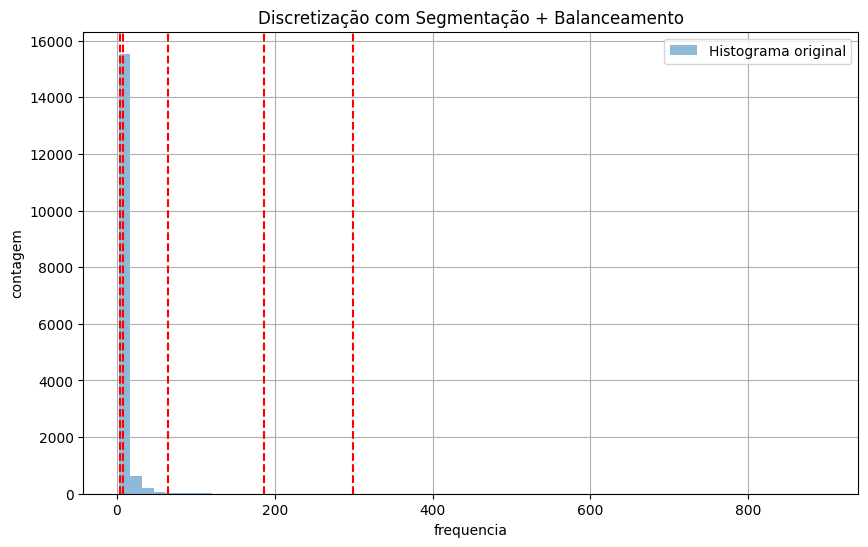

Distribuição das classes:
classe
0    0.579
1    0.225
2    0.196
3    0.000
4    0.000
Name: proportion, dtype: float64


In [33]:

x = np.log1p(df_10_por_cento['frequencia'].values)  # Transformação logarítmica para cauda longa

# 1. Criar histograma
hist, bin_edges = np.histogram(x, bins=50)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# 2. Suavização do histograma (média móvel)
smooth_hist = np.convolve(hist, np.ones(3)/3, mode='same')

# 3. Identificar picos (máximos) e vales (mínimos)
picos, _ = find_peaks(smooth_hist)
vales, _ = find_peaks(-smooth_hist)

# 4. Aplicar critério do artigo (thresholds entre picos)
K = 1.0
thresholds_log = []

for vale in vales:
    left_picos = picos[picos < vale]
    right_picos = picos[picos > vale]
    
    if len(left_picos) > 0 and len(right_picos) > 0:
        g_i = smooth_hist[vale]
        g_j = smooth_hist[left_picos[-1]]  # último pico à esquerda
        g_k = smooth_hist[right_picos[0]]  # primeiro pico à direita

        if (g_j + g_k)/2 > K * g_i:
            thresholds_log.append(bin_centers[vale])

# 5. Voltar para escala original
cut_points = np.expm1(thresholds_log)
cut_points = np.array(sorted(cut_points))
print("Cortes finais na escala original:", cut_points)

# 6. Discretizar os dados
df_10_por_cento['classe'] = np.digitize(df_10_por_cento['frequencia'], bins=cut_points)

# ==== 1. Carregar os dados ====
frequencia_original = df_10_por_cento['frequencia'].values

# ==== 2. Transformar a variável (log1p) ====
x_log = np.log1p(frequencia_original)
#x_log = np.log1p(frequencia_original) / np.log(10)  # log base 10
#x_log = np.log1p(np.log1p(df_10_por_cento['frequencia'].values))

# ==== 3. Criar histograma ====
bins = 60  # mais resolução
hist, bin_edges = np.histogram(x_log, bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ==== 4. Suavização ====
hist_smooth = np.convolve(hist, np.ones(3)/3, mode='same')

# ==== 5. Encontrar picos e vales ====
picos, _ = find_peaks(hist_smooth)
vales, _ = find_peaks(-hist_smooth)

# ==== 6. Aplicar critério do artigo para cortes ====
K = 1.2
thresholds_log = []

for vale in vales:
    left_picos = picos[picos < vale]
    right_picos = picos[picos > vale]
    
    if len(left_picos) > 0 and len(right_picos) > 0:
        g_i = hist_smooth[vale]
        g_j = hist_smooth[left_picos[-1]]  # pico à esquerda
        g_k = hist_smooth[right_picos[0]]  # pico à direita

        if (g_j + g_k) / 2 > K * g_i:
            thresholds_log.append(bin_centers[vale])

# ==== 7. Voltar para escala original ====
cut_points = np.expm1(sorted(thresholds_log))
print("Cortes iniciais:", cut_points)

# ==== 8. Discretizar ====
df_10_por_cento['classe'] = np.digitize(frequencia_original, bins=cut_points)

# ==== 9. Balanceamento – remover classes pequenas ====
min_percent = 0.01  # 1% do total
min_count = int(len(df_10_por_cento) * min_percent)
classe_counts = df_10_por_cento['classe'].value_counts().sort_index()

# Ajustar classes pequenas
for c in classe_counts.index:
    if classe_counts[c] < min_count:
        # Reatribui a classe para a anterior (ou 0 se for a primeira)
        nova_classe = max(0, c - 1)
        df_10_por_cento.loc[df_10_por_cento['classe'] == c, 'classe'] = nova_classe

# Reindexar as classes (opcional, para ter 0, 1, 2, ...)
df_10_por_cento['classe'] = df_10_por_cento['classe'].astype(int)
unique_classes = sorted(df_10_por_cento['classe'].unique())
classe_mapeada = {old: new for new, old in enumerate(unique_classes)}
df_10_por_cento['classe'] = df_10_por_cento['classe'].map(classe_mapeada)

# ==== 10. Visualizar resultado ====
plt.figure(figsize=(10, 6))
plt.hist(frequencia_original, bins=60, alpha=0.5, label='Histograma original')
for cp in cut_points:
    plt.axvline(cp, color='red', linestyle='dashed')
plt.title("Discretização com Segmentação + Balanceamento")
plt.xlabel("frequencia")
plt.ylabel("contagem")
plt.legend()
plt.grid(True)
plt.show()

# ==== 11. Verificar balanceamento final ====
print("Distribuição das classes:")
print(df_10_por_cento['classe'].value_counts(normalize=True).round(3))



In [34]:
print(df_10_por_cento['classe'].value_counts())

classe
0    9560
1    3716
2    3233
3       7
4       4
Name: count, dtype: int64


In [35]:
# Exibir o intervalo de valores para cada quartil
for i in sorted(df_10_por_cento['classe'].unique()):
    subset = df_10_por_cento[df_10_por_cento['classe'] == i]
    minimo = subset['frequencia'].min()
    maximo = subset['frequencia'].max()
    print(f'Classe {i}: de {minimo} até {maximo} mensagens')


Classe 0: de 2 até 4 mensagens
Classe 1: de 5 até 7 mensagens
Classe 2: de 8 até 182 mensagens
Classe 3: de 200 até 240 mensagens
Classe 4: de 335 até 895 mensagens


Cortes iniciais: [  4.05840239   7.13352745  64.74268144 185.90961893 299.53649349]


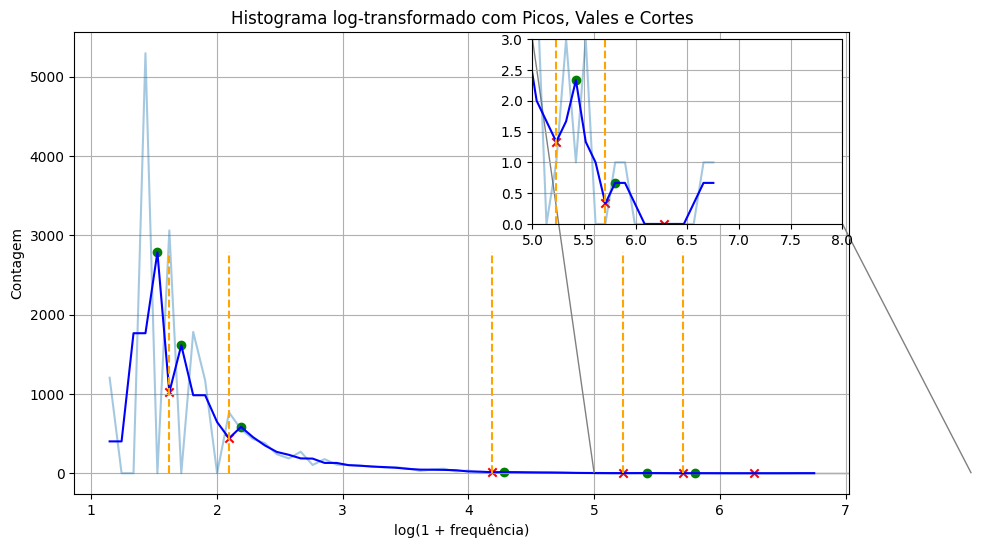

Distribuição das classes:
classe
0    0.579
1    0.225
2    0.196
3    0.000
4    0.000
Name: proportion, dtype: float64


In [36]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# ==== 1. Carregar os dados ====
frequencia_original = df_10_por_cento['frequencia'].values

# ==== 2. Transformar a variável (log1p) ====
x_log = np.log1p(frequencia_original)
#x_log = np.log1p(frequencia_original) / np.log(10)  # log base 10

# ==== 3. Criar histograma ====
bins = 60
hist, bin_edges = np.histogram(x_log, bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ==== 4. Suavização ====
hist_smooth = np.convolve(hist, np.ones(3)/3, mode='same')

# ==== 5. Encontrar picos e vales ====
picos, _ = find_peaks(hist_smooth)
vales, _ = find_peaks(-hist_smooth)

# ==== 6. Aplicar critério do artigo para cortes ====
K = 1.2
thresholds_log = []

for vale in vales:
    left_picos = picos[picos < vale]
    right_picos = picos[picos > vale]
    
    if len(left_picos) > 0 and len(right_picos) > 0:
        g_i = hist_smooth[vale]
        g_j = hist_smooth[left_picos[-1]]
        g_k = hist_smooth[right_picos[0]]

        if (g_j + g_k) / 2 > K * g_i:
            thresholds_log.append(bin_centers[vale])

# ==== 7. Voltar para escala original ====
cut_points = np.expm1(sorted(thresholds_log))
print("Cortes iniciais:", cut_points)

# ==== 8. Discretizar ====
df_10_por_cento['classe'] = np.digitize(frequencia_original, bins=cut_points)

# ==== 9. Balanceamento – remover classes pequenas ====
min_percent = 0.01
min_count = int(len(df_10_por_cento) * min_percent)
classe_counts = df_10_por_cento['classe'].value_counts().sort_index()

for c in classe_counts.index:
    if classe_counts[c] < min_count:
        nova_classe = max(0, c - 1)
        df_10_por_cento.loc[df_10_por_cento['classe'] == c, 'classe'] = nova_classe

df_10_por_cento['classe'] = df_10_por_cento['classe'].astype(int)
unique_classes = sorted(df_10_por_cento['classe'].unique())
classe_mapeada = {old: new for new, old in enumerate(unique_classes)}
df_10_por_cento['classe'] = df_10_por_cento['classe'].map(classe_mapeada)

# ==== 10. Visualização com zoom ====
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico principal
ax.plot(bin_centers, hist, label='Histograma', alpha=0.4)
ax.plot(bin_centers, hist_smooth, label='Histograma suavizado', color='blue')
ax.scatter(bin_centers[picos], hist_smooth[picos], marker='o', color='green', label='Picos')
ax.scatter(bin_centers[vales], hist_smooth[vales], marker='x', color='red', label='Vales')
ax.vlines(thresholds_log, ymin=0, ymax=max(hist_smooth), colors='orange', linestyles='dashed', label='Cortes (log)')
ax.set_title("Histograma log-transformado com Picos, Vales e Cortes")
ax.set_xlabel("log(1 + frequência)")
ax.set_ylabel("Contagem")
ax.legend()
ax.grid(True)

# Janela de zoom
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
axins.plot(bin_centers, hist, alpha=0.4)
axins.plot(bin_centers, hist_smooth, color='blue')
axins.scatter(bin_centers[picos], hist_smooth[picos], marker='o', color='green')
axins.scatter(bin_centers[vales], hist_smooth[vales], marker='x', color='red')
axins.vlines(thresholds_log, ymin=0, ymax=max(hist_smooth), colors='orange', linestyles='dashed')

# Ajuste do zoom
axins.set_xlim(5.0, 8.0)
axins.set_ylim(0, 3)  # Ajuste se necessário conforme os dados
axins.grid(True)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

# ==== 11. Verificar distribuição final ====
print("Distribuição das classes:")
print(df_10_por_cento['classe'].value_counts(normalize=True).round(3))



In [37]:
df_10_por_cento.to_csv('../datasets/10_por_cento_mais_virais_telegram_com_classes_por_corte.csv', index=False)